# Sparkify Project Workspace

## Project Overview
Sparkify, is our fictious music streaming app, and has data regarding its user's actions on its app. It has two main categories of users - free and paid. Paid users pay a premium monthly for few additional benefits. The project is done as a part of Udacity Data Scientist Nanodegree program - Term 2, final Capstone project. 
We intend to use Spark via python (Pyspark) on this project and use its many features. We will initially do some exploratory analysis followed by Feature engineering and Machine learning to solve our actual problem at hand. We will use Spark ML library for this.
## Problem Statement
The project aims to detect users who are more likely to churn - either drop from paid to free, or drop fromt he platform all together based on the past users actions.
## Metrics
We will use accuracy and precision to measure our final output.

## Let's get Started

In [67]:
#import required libraries
import dill

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, count, round, when
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
%store

Stored variables and their in-db values:


In [2]:
#configure and create SparkSession
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-4d449c76-7f2b-4747-8066-f87d101e48e8',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token',
    'api_key': '7tYWBqwk5WpPvT_sCbRQ2b9i7rJUXqPPNmUmD3DinrSM'
}

configuration_name = 'os_8cfb2c45d6df49f6be08767ecc9120d4_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

In [3]:
df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-bmumnu0n9rzxdi'))
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
df.take(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

## Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. We will load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [7]:
df.count()

543705

In [8]:
df = df.dropDuplicates()
df.count()

543705

In [9]:
#check for missing or Null userIds
print(df[df.userId.isNotNull()].count())
print(df[df.userId==""].count())

543705
15700


We have 15,700 records with userId as empty strings. Let's check the same for sessionIds

In [71]:
print(df[df.sessionId.isNotNull()].count())
print(df[df.sessionId==""].count())

543705
0


Dataset does not have any missing values for sessionIds. Let's remove the missing userId records from our dataset and we will be ready for our next step EDA.

In [4]:
df = df[df.userId!=""]
df.count() #check for size

528005

## Exploratory Data Analysis

Let's get top 20 artists songs played count between the free vs paid users

In [5]:
#get overall top 10 artists and their counts
top_artists = df.filter(df.page=="NextSong").groupby("artist").agg(count("artist").alias("total_count")).sort(col("total_count").desc())
top_artists.show(10)

+--------------------+-----------+
|              artist|total_count|
+--------------------+-----------+
|       Kings Of Leon|       3497|
|            Coldplay|       3439|
|Florence + The Ma...|       2314|
|                Muse|       2194|
|       Dwight Yoakam|       2187|
|      The Black Keys|       2160|
|            BjÃÂ¶rk|       2150|
|       Justin Bieber|       2096|
|        Jack Johnson|       2049|
|           Radiohead|       1694|
+--------------------+-----------+
only showing top 10 rows



In [6]:
#limit top artists to top 10 artists
top_artists_pd = top_artists.toPandas()
top_artists_pd = top_artists_pd.head(10)

Similarly pull top artists, their song counts of free users, and top artists, their song counts of paid users.

In [7]:
#get free users top 10 artists and their counts
free_top_artists = df.filter((df.page=="NextSong") & (df.level=="free")).groupby("artist").agg(count("artist").alias("total_count")).sort(col("total_count").desc())

free_top_artists_pd = free_top_artists.toPandas()
free_top_artists_pd = free_top_artists_pd.head(10)
free_top_artists_pd

,artist,total_count
0,Kings Of Leon,654
1,Coldplay,646
2,Florence + The Machine,452
3,The Black Keys,444
4,BjÃÂ¶rk,438
5,Muse,412
6,Dwight Yoakam,411
7,Justin Bieber,393
8,Jack Johnson,382
9,Radiohead,362


In [8]:
#get paid users top 10 artists and their counts
paid_top_artists = df.filter((df.page=="NextSong") & (df.level=="paid")).groupby("artist").agg(count("artist").alias("total_count")).sort(col("total_count").desc())

paid_top_artists_pd = paid_top_artists.toPandas()
paid_top_artists_pd = paid_top_artists_pd.head(10)
paid_top_artists_pd

,artist,total_count
0,Kings Of Leon,2843
1,Coldplay,2793
2,Florence + The Machine,1862
3,Muse,1782
4,Dwight Yoakam,1776
5,The Black Keys,1716
6,BjÃÂ¶rk,1712
7,Justin Bieber,1703
8,Jack Johnson,1667
9,Eminem,1386


Let's plot the above to see the artists remained the same across and how the views changed between levels.

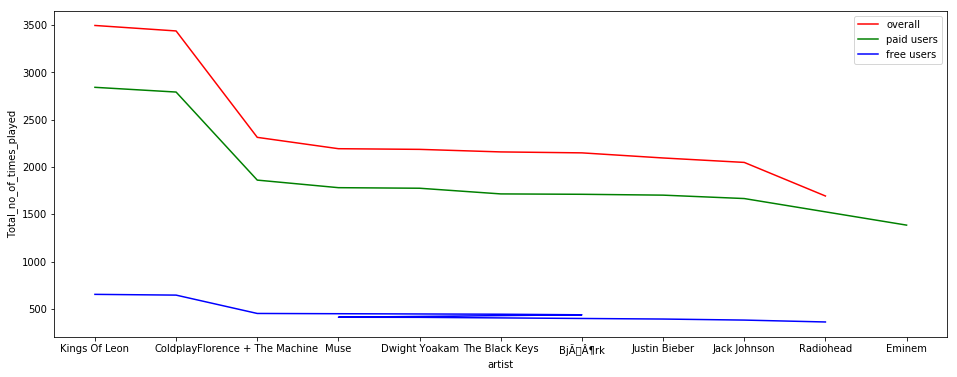

In [10]:
plt.figure(figsize=(16,6))
plt.plot(top_artists_pd["artist"], top_artists_pd["total_count"],'r')
plt.plot(paid_top_artists_pd["artist"], paid_top_artists_pd["total_count"],'g')
plt.plot(free_top_artists_pd["artist"], free_top_artists_pd["total_count"],'b')
plt.legend(labels=["overall","paid users","free users"])
plt.xlabel("artist")
plt.ylabel("Total_no_of_times_played");

We see that there is no major change in the listening preferences between the free and paid users. In general, the number of times songs are listened by paid users is much higher than the free users implying higher engagement of the paid users with Sparkify.

## Identifying users who've Churned/Downgraded

In [23]:
#different Pages available in Sparkify
df.select("page").dropDuplicates().sort("page").show(50)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



* The events causing the Churn is **Cancellation Conf..** 
* Similarly, event causing the downgrade is **Submit Downgrade**

In [9]:
#create udf to check if action page is churn related
churn_event = udf(lambda x: 1 if x =="Cancellation Confirmation" else 0, IntegerType())

In [10]:
#create column to identify churn users 
churn_users = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_users_list = [(row['userId']) for row in churn_users.collect()]
df = df.withColumn("churn", df.userId.isin(churn_users_list))

In [11]:
#create udf to check if action page is downgrade related
downgrade_event = udf(lambda x: 1 if x =="Submit Downgrade" else 0, IntegerType())

In [12]:
#create column to identify downgrade users
downgrade_users = df.filter(df.page=="Submit Downgrade").select("userId").dropDuplicates()
downgrade_users_list = [(row['userId']) for row in downgrade_users.collect()]
df = df.withColumn("downgrade", df.userId.isin(downgrade_users_list))

In [36]:
#sanity check
df.where(df.page=="Submit Downgrade").take(5)

[Row(artist=None, auth='Logged In', firstName='Carter', gender='M', itemInSession=117, lastName='Cook', length=None, level='paid', location='Chicago-Naperville-Elgin, IL-IN-WI', method='PUT', page='Submit Downgrade', registration=1522793334000, sessionId=287, song=None, status=307, ts=1538382247000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='288', churn=True, downgrade=True),
 Row(artist=None, auth='Logged In', firstName='Aurora', gender='F', itemInSession=105, lastName='Humphrey', length=None, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='Submit Downgrade', registration=1536795126000, sessionId=537, song=None, status=307, ts=1538447915000, userAgent='"Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='127', churn=False, downgrade=True),
 Row(artist=None, auth='Logged I

In [18]:
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, Churn: int, Downgrade: int]

In [40]:
#count of churned users by gender
df.dropDuplicates(['gender','userid']).groupby('gender','churn').count().sort('churn').show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     F|false|  153|
|     M|false|  196|
|     M| true|   54|
|     F| true|   45|
+------+-----+-----+



### Compare churned users behaviour with non-churn users

#### Compare Song counts for different week days

In [13]:
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
df = df.withColumn("weekday", get_weekday(df.ts))

In [14]:
#create Churn and non_churn Pandas df for plots
df_churn = df.where('churn=1')
df_nonchurn = df.where('churn=0')

In [15]:
#get song counts for churn and non_churn users by day
df_weekday_pd = df['gender','page','userid','churn','weekday'].filter(df.page == 'NextSong') \
                                                    .groupby('churn', 'weekday').count().orderBy(df['weekday'].cast('float')).toPandas()
df_weekday_churn_pd = df_weekday_pd[df_weekday_pd['churn']==1]
df_weekday_nonchurn_pd = df_weekday_pd[df_weekday_pd['churn']==0]

In [22]:
df_weekday_pd.head(20)

,churn,weekday,count
0,True,0,7275
1,False,0,25157
2,True,1,12570
3,False,1,53217
4,False,2,56200
5,True,2,15215
6,True,3,13129
7,False,3,58164
8,False,4,59598
9,True,4,14426


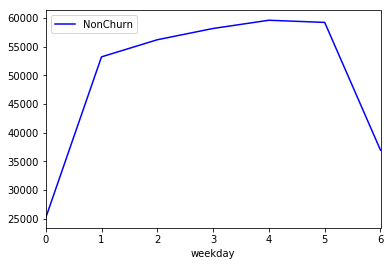

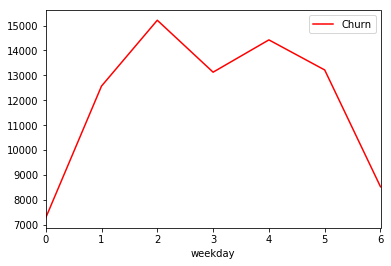

In [23]:
df_weekday_nonchurn_pd.plot(x="weekday",y="count",color='Blue',label='NonChurn')
df_weekday_churn_pd.plot(x="weekday",y="count",color='Red', label='Churn')

Non-Churn users generally have a consistent listening counts during weekdays, while there is a little inconsistency amongst the Churned users even during weekdays.

## Feature Engineering

In order to build our model, let's engineer a few features which we think may play a significant factor in deciding whether a user may churn or not.

**Feature 1:** Average number of songs listened by a user in each session
* Hypothesis: If a user is there for longer duration in each session he/she will see more value and benefits of Sparkify and is less likely to churn *

In [16]:
user_session_songcount = df.select('userId','page','sessionId').filter(df.page == 'NextSong').groupby('userId','sessionId').count()
feature1_songs_session = user_session_songcount.groupby("userId").agg(round(avg('count'),2).alias('songs_per_session'))

In [17]:
feature1_songs_session.show(5)

+------+-----------------+
|userId|songs_per_session|
+------+-----------------+
|200002|             62.0|
|   296|             22.4|
|100010|             48.0|
|   125|            20.67|
|   124|           114.13|
+------+-----------------+
only showing top 5 rows



**Feature 2:** Total number of sessions of a user
* Hypothesis: If the user is less frequent on the platform, he/she will probably churn *

In [31]:
feature2_session_count = df.select('userId','sessionId').dropDuplicates().groupby('userId').count() \
                                    .withColumnRenamed('count','session_count')
feature2_session_count.show(5)

+------+-------------+
|userId|session_count|
+------+-------------+
|100010|            2|
|   296|            5|
|200002|            5|
|   125|            3|
|     7|           15|
+------+-------------+
only showing top 5 rows



**Feature 3:** Average number of different Pages visited in each session

In [19]:
user_session_pagecount = df.select('userId','page','sessionId').dropDuplicates().groupby('userId','sessionId').count()
feature3_page_session = user_session_pagecount.groupby("userId").agg(round(avg('count'),2).alias('pages_per_session'))

In [20]:
feature3_page_session.show(5)

+------+-----------------+
|userId|pages_per_session|
+------+-----------------+
|100010|              8.5|
|200002|              8.0|
|   296|              5.4|
|   125|             5.67|
|     7|             5.73|
+------+-----------------+
only showing top 5 rows



**Feature 4:** Gender of user

* It is important to check if Sparkify has any gender related affinity from any particular gender. 
* We will encode the Gender values into 1s and 0s

In [23]:
feature4_gender = df.select('userId','gender').dropDuplicates() \
                    .replace(['M','F'],['1','0'],'gender')
feature4_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|   188|     0|
|   234|     1|
|    44|     0|
|   273|     1|
|    46|     0|
+------+------+
only showing top 5 rows



**Feature 5:** Current User level - Paid or free
* Hypothesis: User is likely to stay longer if the user is a paid user

In [24]:
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, churn: boolean, downgrade: boolean, weekday: string]

In [32]:
feature5_level = df.where(df.downgrade==False).select('userId','level').dropDuplicates() \
                                    .replace(['paid','free'],['1','0'],'level')
feature5_level.show(5)

+------+-----+
|userId|level|
+------+-----+
|    94|    1|
|   185|    0|
|200021|    0|
|   241|    1|
|200001|    0|
+------+-----+
only showing top 5 rows



**Feature 6:** Average session time for a user
* Hypothesis: More the average session time for a user, he'she is less likely to churn from the platform.

In [51]:
avg_session = df.groupby('userId','sessionId').agg(round(((max('ts')-min('ts'))/(1000*60)),2).alias('session_time')).dropDuplicates()
feature6_avg_session_time = avg_session.groupby('userId').agg(round(avg('session_time'),2).alias('avg_session_time'))
feature6_avg_session_time.show(5)                                                    

+------+----------------+
|userId|avg_session_time|
+------+----------------+
|   296|           97.04|
|100010|          210.38|
|200002|          263.06|
|   125|           84.98|
|   124|          445.67|
+------+----------------+
only showing top 5 rows



**Feature 7:** Number of times user visited different pages in total
* Hypothesis: The way user browses different pages on Sparkify may give us some insight into which users will churn depending on the different pages he chooses to access.

In [56]:
#check all page names available
df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



We will create features only for those Pages which are generic and **NOT** one time in nature, like Downgrade, or Cancellation.

In [62]:
feature7_thumbs_down = df.where(df.page=='Thumbs Down').groupby('userId').count() \
                            .withColumnRenamed('count','thumbs_down_count')
feature7_thumbs_down.show(5)

+------+-----------------+
|userId|thumbs_down_count|
+------+-----------------+
|100010|                3|
|200002|                5|
|   125|                1|
|   124|               15|
|    51|                1|
+------+-----------------+
only showing top 5 rows



In [64]:
feature7_thumbs_up = df.where(df.page=='Thumbs Up').groupby('userId').count() \
                            .withColumnRenamed('count','thumbs_up_count')
feature7_home = df.where(df.page=='Home').groupby('userId').count() \
                            .withColumnRenamed('count','home_count')
feature7_roll_advert = df.where(df.page=='Roll Advert').groupby('userId').count() \
                            .withColumnRenamed('count','roll_advert_count')
feature7_logout = df.where(df.page=='Logout').groupby('userId').count() \
                            .withColumnRenamed('count','logout_count')
feature7_save_settings = df.where(df.page=='Save Settings').groupby('userId').count() \
                            .withColumnRenamed('count','save_settings_count')
feature7_settings = df.where(df.page=='Settings').groupby('userId').count() \
                            .withColumnRenamed('count','settings_count')
feature7_about = df.where(df.page=='About').groupby('userId').count() \
                            .withColumnRenamed('count','save_settings_count')
feature7_add_to_playlist = df.where(df.page=='Add to Playlist').groupby('userId').count() \
                            .withColumnRenamed('count','add_to_playlist_count')
feature7_add_friend = df.where(df.page=='Add Friend').groupby('userId').count() \
                            .withColumnRenamed('count','add_friend_count')
feature7_nextsong = df.where(df.page=='NextSong').groupby('userId').count() \
                            .withColumnRenamed('count','nextsong_count')
feature7_help = df.where(df.page=='Help').groupby('userId').count() \
                            .withColumnRenamed('count','help_count')
feature7_error = df.where(df.page=='Error').groupby('userId').count() \
                            .withColumnRenamed('count','error_count')

**Feature 8:** If a user has downgraded
* Hypothesis: A downgraded user is more likely to churn.

In [69]:
feature8_downgrade = df.select('userId','downgrade').dropDuplicates() \
                        .withColumn('downgraded',when(df.downgrade == True, '1').otherwise('0')).select('userid','downgraded')
feature8_downgrade.show(5)

+------+----------+
|userid|downgraded|
+------+----------+
|    19|         0|
|    69|         1|
|    73|         0|
|   139|         1|
|100034|         0|
+------+----------+
only showing top 5 rows



As we cannot replace Boolean values with 1s and 0s, we have created a new column for our feature based on Downgrade column.

**Final Output Label: Churn**

In [71]:
df_final = df.select('userId','churn').dropDuplicates() \
                        .withColumn('churned',when(df.churn == True, '1').otherwise('0')).select('userid','churned')
df_final.show(5)

+------+-------+
|userid|churned|
+------+-------+
|    73|      0|
|    19|      0|
|   209|      0|
|100005|      1|
|100030|      1|
+------+-------+
only showing top 5 rows



**Merge all features and final outcome label into one dataframe**

In [72]:
df_final = df_final.join(feature1_songs_session, df_final.userId == feature1_songs_session.userId, "left")
df_final.show(5)

AttributeError: 'DataFrame' object has no attribute 'userId'